# Introduction
Building a 3D CNN to predict the presence of viral pneumonia in CT scans

In [1]:
import os
import zipfile 
import numpy as np
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# The MosMedData 
Consists of lung CT scans with COVID-19 related findigs as well as without such findings

In [3]:
# Download url of normal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-0.zip"
filename = os.path.join(os.getcwd(), "CT-0.zip")
keras.utils.get_file(filename, url)

# Download url of abnormal CT scans.
url = "https://github.com/hasibzunair/3D-image-classification-tutorial/releases/download/v0.2/CT-23.zip"
filename = os.path.join(os.getcwd(), "CT-23.zip")
keras.utils.get_file(filename, url)

# Make a directory to store the data.
os.makedirs("MosMedData")

# Unzip data in the newly created directory.
with zipfile.ZipFile("CT-0.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

with zipfile.ZipFile("CT-23.zip", "r") as z_fp:
    z_fp.extractall("./MosMedData/")

1045162547/1045162547 [==============================] - 1061s 1us/step


In [2]:
import nibabel as nib
from scipy import ndimage

In [3]:
def read_nifti_file(filepath):
    scan = nib.load(filepath)
    scan = scan.get_fdata()
    
    return scan

def normalize(volume):
    min_scale, max_scale = -1000, 400
    
    volume[volume < min_scale] = min_scale
    volume[volume > max_scale] = max_scale
    
    volume = (volume - min_scale) / (max_scale - min_scale)
    volume = volume.astype("float32")
    
    return volume

def resize_volume(img):
    
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    
    img = ndimage.rotate(img, 90, reshape=False)
    
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=1)
    
    return img

def process_scan(path):
    
    volume = read_nifti_file(path)
    volume = normalize(volume)
    volume = resize_volume(volume)
    
    return volume

In [4]:
normal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-0", x) 
    for x in os.listdir("MosMedData/CT-0")
]

abnormal_scan_paths = [
    os.path.join(os.getcwd(), "MosMedData/CT-23", x)
    for x in os.listdir("MosMedData/CT-23")
]

print("CT scans with normal lung tissue: ", len(normal_scan_paths))
print("CT scans with abnormal lung tissue: ", len(abnormal_scan_paths))

CT scans with normal lung tissue:  100
CT scans with abnormal lung tissue:  100


In [5]:
abnormal_scans = np.array([process_scan(path) for path in abnormal_scan_paths])
normal_scans = np.array([process_scan(path) for path in normal_scan_paths])

abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

x_train = np.concatenate((abnormal_scans[:70], normal_scans[:70]), axis=0)
y_train = np.concatenate((abnormal_labels[:70], normal_labels[:70]), axis=0)
x_val = np.concatenate((abnormal_scans[70:], normal_scans[70:]), axis=0)
y_val = np.concatenate((abnormal_labels[70:], normal_labels[70:]), axis=0)

print("Number of samples in train and validation are: ", x_train.shape[0], 
      "and ", x_val.shape[0], "respectively")

KeyboardInterrupt: 

In [32]:
example_vol_path = '/media/hacen/3a0ab16a-82f1-416c-902d-3c782e61d1ec/medicaldecathlon/Task09_Spleen/imagesTr/spleen_2.nii.gz'

In [33]:
vol = process_scan(example_vol_path)

In [34]:
vol.shape

(128, 128, 64)

In [49]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

In [30]:
import matplotlib.pyplot as plt

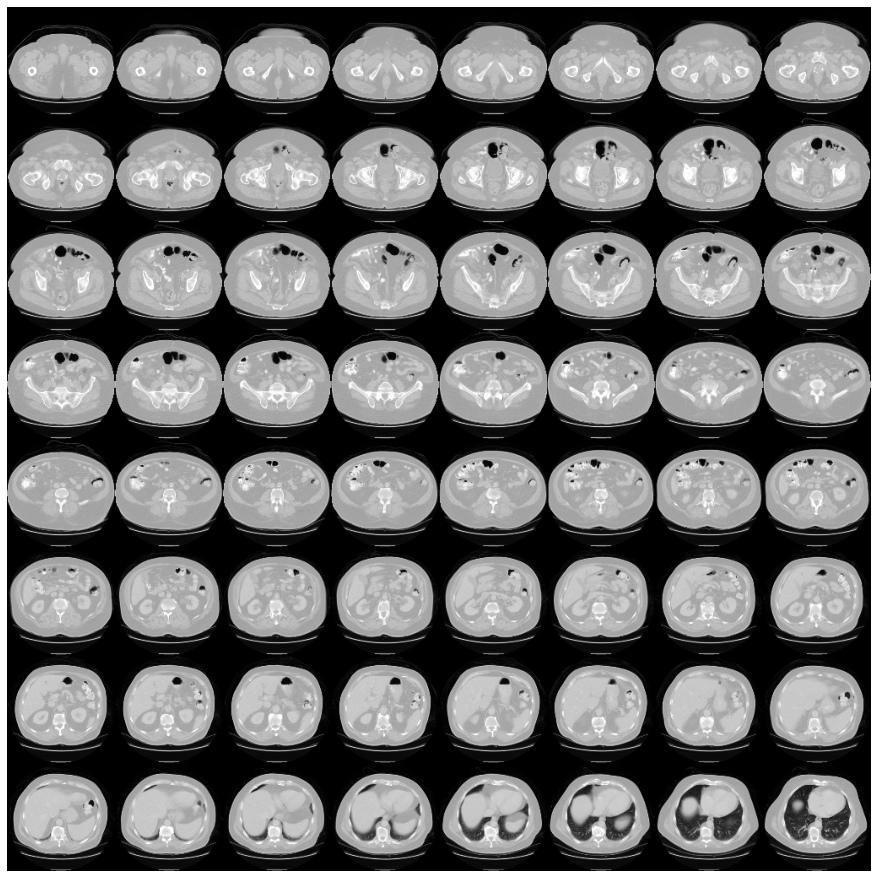

In [50]:
plot_slices(8, 8, 128, 128, vol[:, :, :])

In [55]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of coronal slices"""
#     data = np.rot90(np.array(data))
    data = np.transpose(data, axes=(0, 2, 1))  # Transpose the axes to switch axial and coronal slices
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

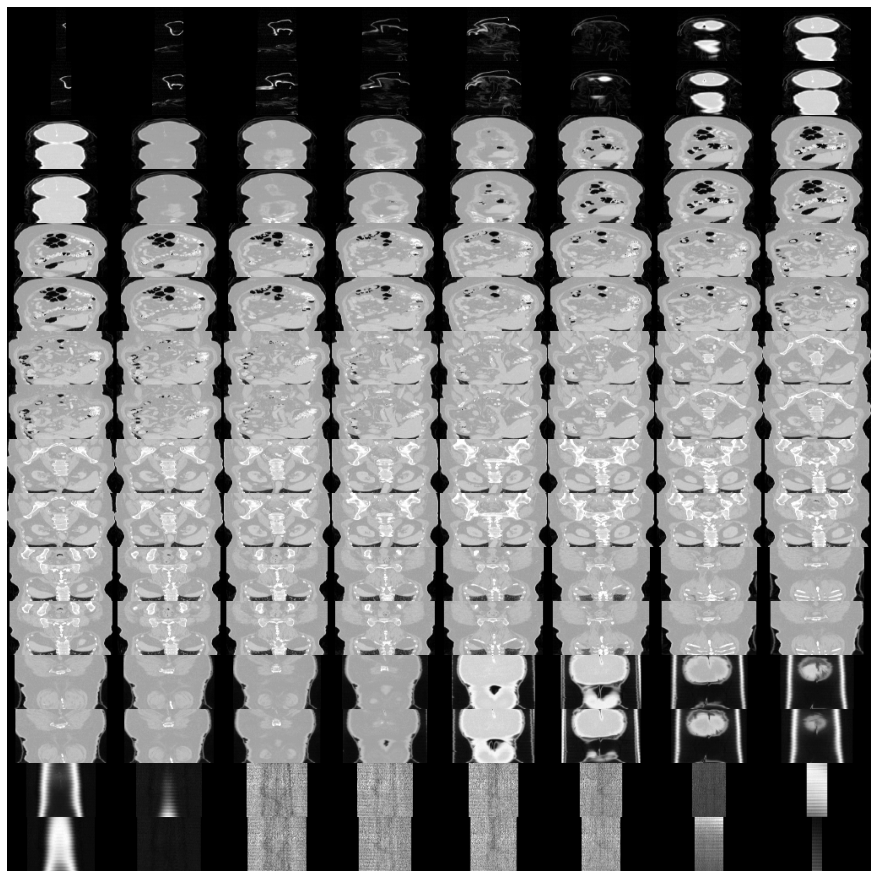

In [56]:
plot_slices(8, 8, 128, 128, vol[:, :, :])

In [53]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of sagittal slices"""
#     data = np.rot90(np.array(data), k=1)  # Rotate the data 90 degrees clockwise
    data = np.transpose(data, axes=(1, 2, 0))  # Transpose the axes to switch axial and sagittal slices
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()

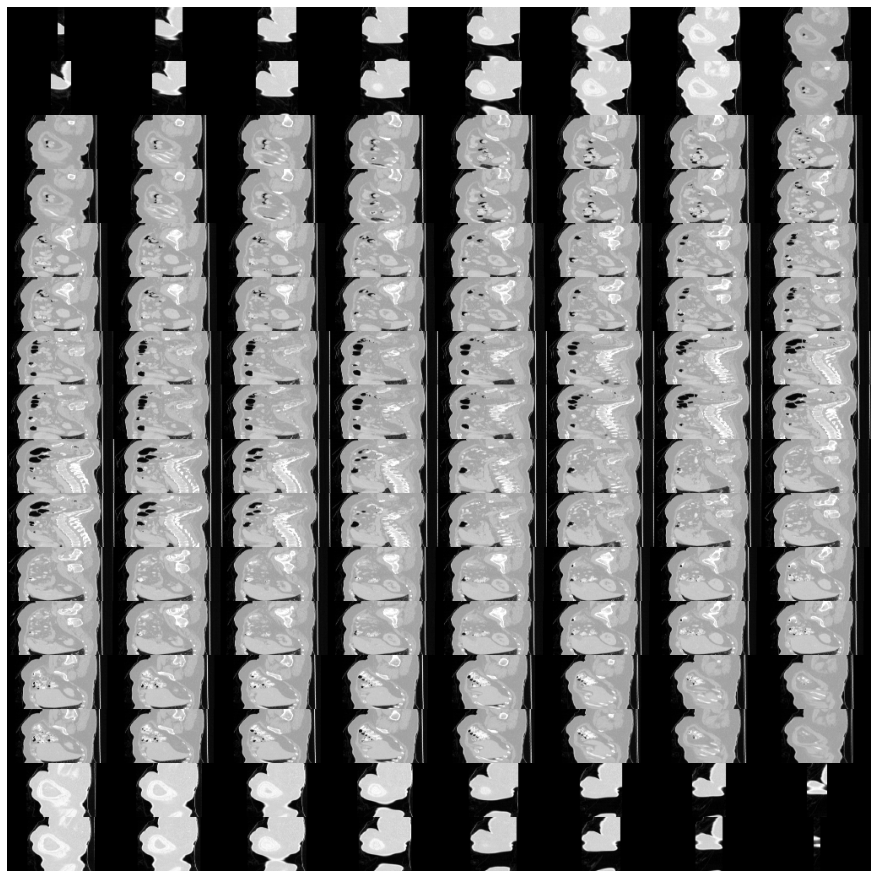

In [54]:
plot_slices(8, 8, 128, 128, vol[:, :, :])